In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from bs4 import BeautifulSoup
import xgboost as xgb
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from string import punctuation
from textblob import Word 
from gensim.parsing.preprocessing import remove_stopwords
from nltk.stem import WordNetLemmatizer 
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier

# Data Preprocessing

In [2]:
reviews = pd.read_csv('reviews.csv', header=0, names=["Review", "Sentiment"])
reviews.head()

,Review,Sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
# create the copy for LSTM (the data will be processed slightly differently)
reviews_lstm = reviews.copy()
reviews_lstm["Review"] = reviews_lstm["Review"].apply(lambda x: BeautifulSoup(x, "lxml").text)
reviews_lstm["Sentiment"] = reviews_lstm["Sentiment"].apply(lambda x: 0 if x in "negative" else 1)

In [4]:
# check for missing values 
print(f"Number of missing values in the dataset: {sum(reviews.isna().sum())}")
print("")
# check for empty reviews
print(f"Number of empty reviews: {len(reviews[reviews['Review'].apply(lambda x: x=='')])}")

Number of missing values in the dataset: 0

Number of empty reviews: 0


In [5]:
# I could not install contractions library for some reason (some users mention that there are 
# issues with the support of versions later than Python 3.6). Thus, I copied the data from the
# source code: https://github.com/kootenpv/contractions/blob/master/contractions/data/contractions_dict.json
contractions = {
    "I'm": "I am",
    "I'm'a": "I am about to",
    "I'm'o": "I am going to",
    "I've": "I have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'd": "I would",
    "I'd've": "I would have",
    "Whatcha": "What are you",
    "amn't": "am not",
    "ain't": "are not",
    "aren't": "are not",
    "'cause": "because",
    "can't": "cannot",
    "can't've": "cannot have",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "daren't": "dare not",
    "daresn't": "dare not",
    "dasn't": "dare not",
    "didn't": "did not",
    "didn’t": "did not",
    "don't": "do not",
    "don’t": "do not",
    "doesn't": "does not",
    "e'er": "ever",
    "everyone's": "everyone is",
    "finna": "fixing to",
    "gimme": "give me",
    "gon't": "go not",
    "gonna": "going to",
    "gotta": "got to",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he've": "he have",
    "he's": "he is",
    "he'll": "he will",
    "he'll've": "he will have",
    "he'd": "he would",
    "he'd've": "he would have",
    "here's": "here is",
    "how're": "how are",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how's": "how is",
    "how'll": "how will",
    "isn't": "is not",
    "it's": "it is",
    "'tis": "it is",
    "'twas": "it was",
    "it'll": "it will",
    "it'll've": "it will have",
    "it'd": "it would",
    "it'd've": "it would have",
    "kinda": "kind of",
    "let's": "let us",
    "luv": "love",
    "ma'am": "madam",
    "may've": "may have",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "ne'er": "never",
    "o'": "of",
    "o'clock": "of the clock",
    "ol'": "old",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "o'er": "over",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shalln't": "shall not",
    "shan't've": "shall not have",
    "she's": "she is",
    "she'll": "she will",
    "she'd": "she would",
    "she'd've": "she would have",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "somebody's": "somebody is",
    "someone's": "someone is",
    "something's": "something is",
    "sux": "sucks",
    "that're": "that are",
    "that's": "that is",
    "that'll": "that will",
    "that'd": "that would",
    "that'd've": "that would have",
    "em": "them",
    "there're": "there are",
    "there's": "there is",
    "there'll": "there will",
    "there'd": "there would",
    "there'd've": "there would have",
    "these're": "these are",
    "they're": "they are",
    "they've": "they have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they'd": "they would",
    "they'd've": "they would have",
    "this's": "this is",
    "those're": "those are",
    "to've": "to have",
    "wanna": "want to",
    "wasn't": "was not",
    "we're": "we are",
    "we've": "we have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we'd": "we would",
    "we'd've": "we would have",
    "weren't": "were not",
    "what're": "what are",
    "what'd": "what did",
    "what've": "what have",
    "what's": "what is",
    "what'll": "what will",
    "what'll've": "what will have",
    "when've": "when have",
    "when's": "when is",
    "where're": "where are",
    "where'd": "where did",
    "where've": "where have",
    "where's": "where is",
    "which's": "which is",
    "who're": "who are",
    "who've": "who have",
    "who's": "who is",
    "who'll": "who will",
    "who'll've": "who will have",
    "who'd": "who would",
    "who'd've": "who would have",
    "why're": "why are",
    "why'd": "why did",
    "why've": "why have",
    "why's": "why is",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "you're": "you are",
    "you've": "you have",
    "you'll've": "you shall have",
    "you'll": "you will",
    "you'd": "you would",
    "you'd've": "you would have"
 }

In [6]:
def clean(df):
    """
    Cleans the input and standardizes it
    
    Returns: cleaned and processed version of the text
    """
    
    # remove html tags
    df["Review"] = df["Review"].apply(lambda x: BeautifulSoup(x, "lxml").text)
    print("Removed html tags")
    
    # deal with contractions
    for idx in range(df["Review"].shape[0]):
        review = df["Review"].iloc[idx].split()
        fixed = []
        for word in review:
            if word in contractions:
                fixed.append(contractions[word])
            else:
                fixed.append(word)
        review = " ".join(fixed)
        df["Review"].iloc[idx] = review

    print("Fixed contractions")
                
    # remove punctuation
    df["Review"] = df["Review"].apply(lambda words:
                                      words.translate(str.maketrans('','', punctuation)))
    print("Removed punctuation")
    
    # remove stopwords
    df["Review"] = df["Review"].apply(lambda text: remove_stopwords(text))
    print("Removed stopwords")
    
    # tokenize words
    df["Review"] = df["Review"].apply(word_tokenize)
    print("Tokenized words")
    
    # convert to lowercase
    df["Review"] = df["Review"].apply(lambda text: [w.lower() for w in text])
    print("Converted to lowercase")
    
    # remove numbers 
    df["Review"] = df["Review"].apply(lambda words: [x for x in words if not 
                                                     x.isdigit()])
    print("Removed numbers")
    
    # initialize the Wordnet Lemmatizer
    lemmatizer = WordNetLemmatizer()
    # lemmatize words
    df["Review"] = df["Review"].apply(lambda 
                                      words: " ".join([lemmatizer.lemmatize(x) 
                                      for x in words]))
    print("Lemmatized words")
    return df

In [7]:
# processed
reviews = clean(reviews)

Removed html tags
Fixed contractions
Removed punctuation
Removed stopwords
Tokenized words
Converted to lowercase
Removed numbers
Lemmatized words


Positive Words


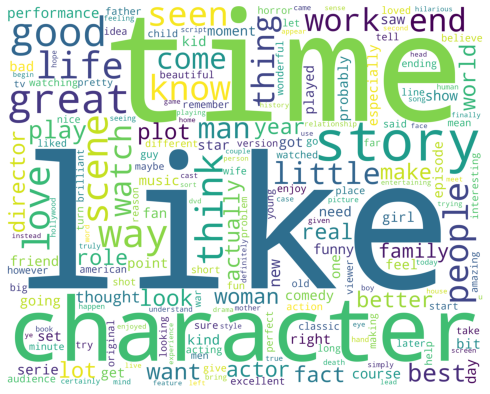

Negative Words


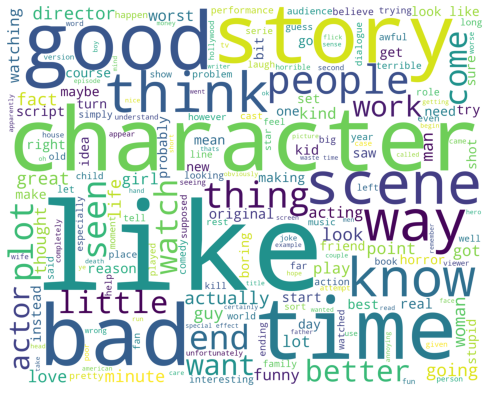

In [8]:
# borrowed from https://medium.com/hackerdawn/imdb-review-sentiment-analysis-using-logistic-regression-d7878ee01947
from wordcloud import WordCloud

# convert the format of dependent variable to integer output
reviews["Sentiment"] = reviews["Sentiment"].apply(lambda x: 0 if x in "negative" else 1)

def wordcloud_draw(data, color = 'white'):
    """
    Input:
    data(Pandas Dataframe): data with different review types
    color(str): background color of the diagram
    -------------------------------------------------------
    
    Returns: Diagram with the most frequent words associated with each review type
    """
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                              if(word!='movie' and word!='film')
                            ])
    wordcloud = WordCloud(stopwords=stopwords.words('english'),
                      background_color=color,
                      width=2500,
                      height=2000).generate(cleaned_word)
    plt.figure(1,figsize=(10, 7))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
# split all reviews into positive and negative
positive_reviews = reviews[reviews["Sentiment"]==1]
negative_reviews = reviews[reviews["Sentiment"]==0]
print("Positive Words")
wordcloud_draw(positive_reviews["Review"])
print("Negative Words")
wordcloud_draw(negative_reviews["Review"])

In [9]:
X = reviews.Review
y = reviews.Sentiment
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, stratify=y)

# Base Model

In [10]:
# define the cross-validation type
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
grid_base_model = {'solver': ['liblinear'], 
        'penalty': ['l1', 'l2'],
        'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}

# pipeline
base_model = Pipeline(steps =[
('preprocessing', CountVectorizer()),
('classifier', GridSearchCV(LogisticRegression(),
                            grid_base_model, cv=cv, scoring='accuracy'))
])

In [11]:
# execute search
res_base_model = base_model.fit(X_train, y_train)

In [12]:
# summarize results
print(f'Mean cross-validated score: {round(res_base_model["classifier"].best_score_, 4)*100}%')
print(f'Parameter setting that gave the best results on the hold out data: '
      f'{res_base_model["classifier"].best_params_}')

Mean cross-validated score: 88.47%
Parameter setting that gave the best results on the hold out data: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [13]:
# test set predictions
preds_base_model = base_model.predict(X_test)
print(f"Accuracy score on the test set: "
      f"{round(accuracy_score(y_test, preds_base_model), 4)*100}%") 

Accuracy score on the test set: 88.74%


In [14]:
print(classification_report(y_test, preds_base_model))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      6250
           1       0.88      0.90      0.89      6250

    accuracy                           0.89     12500
   macro avg       0.89      0.89      0.89     12500
weighted avg       0.89      0.89      0.89     12500



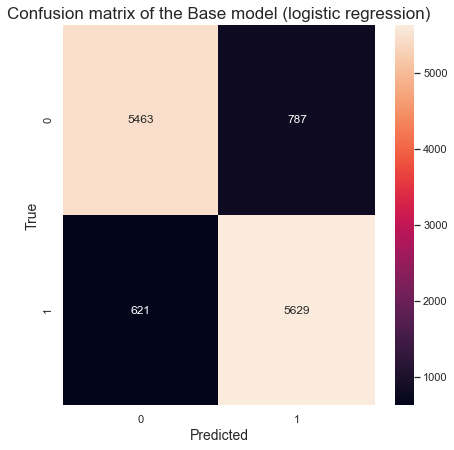

In [15]:
# confusion matrix for the base model
base_cm = confusion_matrix(y_test, preds_base_model)
plt.figure(figsize=(7,7))
plt.title('Confusion matrix of the Base model (logistic regression)', size=17)
seaborn.heatmap(base_cm,annot=True, fmt="d")
plt.xlabel('Predicted', size=14)
plt.ylabel('True', size=14)
plt.ioff()
plt.show()

# Decision Tree

In [16]:
# parameters borrowed from https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost

# define search space
grid_xgb_model = {'min_child_weight': [1, 5, 10, 15],
                  'gamma': [0.5, 1, 1.5, 2, 5, 10],
                  'subsample': [0.4, 0.6, 0.8, 1.0],
                  'max_depth': [3, 4, 5, 6]}

# pipeline for the XGBoost model
xgb_model = Pipeline(steps =[
('preprocessing', CountVectorizer()),
('classifier', RandomizedSearchCV(xgb.XGBClassifier(objective='binary:logistic', 
                                              use_label_encoder=False, eval_metric='error'),
                                     grid_xgb_model, scoring='accuracy', cv=cv))
])

In [17]:
# execute search
res_xgb_model = xgb_model.fit(X_train, y_train)

In [18]:
# summarize results
print(f'Mean cross-validated score: {round(res_xgb_model["classifier"].best_score_, 4)*100}%')
print(f'Parameter setting that gave the best results on the hold out data: '
      f'{res_xgb_model["classifier"].best_params_}')

Mean cross-validated score: 85.41%
Parameter setting that gave the best results on the hold out data: {'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 6, 'gamma': 10}


In [19]:
# test set predictions
preds_xgb_model = xgb_model.predict(X_test)
print(f"Accuracy score on the test set: "
      f"{round(accuracy_score(y_test, preds_xgb_model), 4)*100}%") 

Accuracy score on the test set: 85.22999999999999%


In [20]:
print(classification_report(y_test, preds_xgb_model))

              precision    recall  f1-score   support

           0       0.87      0.82      0.85      6250
           1       0.83      0.88      0.86      6250

    accuracy                           0.85     12500
   macro avg       0.85      0.85      0.85     12500
weighted avg       0.85      0.85      0.85     12500



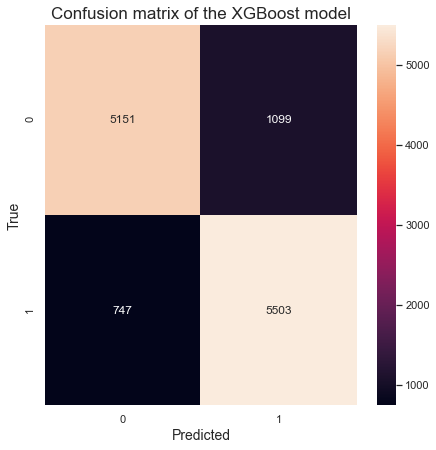

In [21]:
# confusion matrix of the XGBoost model
xgb_cm = confusion_matrix(y_test, preds_xgb_model)
plt.figure(figsize=(7,7))
plt.title('Confusion matrix of the XGBoost model', size=17)
seaborn.heatmap(xgb_cm,annot=True, fmt="d")
plt.xlabel('Predicted', size=14)
plt.ylabel('True', size=14)
plt.ioff()
plt.show()

# Neural Network

In [22]:
# max number of words to store in the vocabulary
max_features = 5000
# max sequence length
max_length = 50
tokenizer = Tokenizer(oov_token = "<OOV>", num_words=max_features)
tokenizer.fit_on_texts(reviews_lstm["Review"])
# turn a sequence of words into array of integers
X_lstm = tokenizer.texts_to_sequences(reviews_lstm["Review"])
# add padding (0) if necessary so that the sequence length is the same
X_lstm = pad_sequences(X_lstm, padding='post', maxlen=max_length)
y_lstm = reviews_lstm["Sentiment"]

In [23]:
# split the dataset into train (with a subset for testing GridSearchCV) and test
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm,
                                                                        y_lstm, 
                                                                        test_size = 0.25, 
                                                                        stratify=y_lstm)

X_train_lstm, X_sub_lstm, y_train_lstm, y_sub_lstm = train_test_split(X_train_lstm,
                                                                y_train_lstm, 
                                                                test_size = 0.10, 
                                                                stratify = y_train_lstm)                                                                  

In [24]:
def build_lstm_model():
    """
    Builds an LSTM model
    
    Returns: deep neural network object
    """
    model = Sequential()
    model.add(Embedding(max_features, 10, input_length=max_length))
    model.add(Dropout(0.3))
    model.add(LSTM(100))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

model = KerasClassifier(build_fn=build_lstm_model, verbose=0)

In [30]:
# define callbacks
checkpoint_filepath = './tmp/checkpoint'
callbacks = [EarlyStopping(monitor="val_loss", patience=5, 
                           verbose=1, mode="min", 
                           restore_best_weights=True),
             ModelCheckpoint(filepath=checkpoint_filepath,
                             save_weights_only=True,
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True)]

In [26]:
# define search space
grid_lstm_model = {'batch_size': [20, 50, 100, 150],
                  'epochs': [10, 20]}

In [27]:
lstm_model = GridSearchCV(model, grid_lstm_model, cv=cv,
                          scoring='accuracy', verbose=2)
# execute search
res_lstm_model = lstm_model.fit(X_sub_lstm, y_sub_lstm)

Fitting 30 folds for each of 8 candidates, totalling 240 fits
[CV] END ...........................batch_size=20, epochs=10; total time=  35.6s
[CV] END ...........................batch_size=20, epochs=10; total time=  33.2s
[CV] END ...........................batch_size=20, epochs=10; total time=  32.5s
[CV] END ...........................batch_size=20, epochs=10; total time=  31.6s
[CV] END ...........................batch_size=20, epochs=10; total time=  36.5s
[CV] END ...........................batch_size=20, epochs=10; total time=  33.8s
[CV] END ...........................batch_size=20, epochs=10; total time=  32.3s
[CV] END ...........................batch_size=20, epochs=10; total time=  32.4s
[CV] END ...........................batch_size=20, epochs=10; total time=  38.4s
[CV] END ...........................batch_size=20, epochs=10; total time=  34.6s
[CV] END ...........................batch_size=20, epochs=10; total time=  34.2s
[CV] END ...........................batch_size=

[CV] END ...........................batch_size=50, epochs=20; total time=  44.1s
[CV] END ...........................batch_size=50, epochs=20; total time=  46.4s
[CV] END ...........................batch_size=50, epochs=20; total time=  46.4s
[CV] END ...........................batch_size=50, epochs=20; total time=  55.4s
[CV] END ...........................batch_size=50, epochs=20; total time=  48.2s
[CV] END ...........................batch_size=50, epochs=20; total time=  47.0s
[CV] END ...........................batch_size=50, epochs=20; total time=  46.5s
[CV] END ...........................batch_size=50, epochs=20; total time=  47.4s
[CV] END ...........................batch_size=50, epochs=20; total time=  52.0s
[CV] END ...........................batch_size=50, epochs=20; total time=  51.2s
[CV] END ...........................batch_size=50, epochs=20; total time=  48.5s
[CV] END ...........................batch_size=50, epochs=20; total time=  49.0s
[CV] END ...................

[CV] END ..........................batch_size=150, epochs=10; total time=  21.3s
[CV] END ..........................batch_size=150, epochs=10; total time=  21.6s
[CV] END ..........................batch_size=150, epochs=10; total time=  21.7s
[CV] END ..........................batch_size=150, epochs=10; total time=  24.1s
[CV] END ..........................batch_size=150, epochs=10; total time=  22.1s
[CV] END ..........................batch_size=150, epochs=10; total time=  20.1s
[CV] END ..........................batch_size=150, epochs=10; total time=  19.7s
[CV] END ..........................batch_size=150, epochs=20; total time=  34.6s
[CV] END ..........................batch_size=150, epochs=20; total time=  35.2s
[CV] END ..........................batch_size=150, epochs=20; total time=  40.9s
[CV] END ..........................batch_size=150, epochs=20; total time=  44.2s
[CV] END ..........................batch_size=150, epochs=20; total time=  42.1s
[CV] END ...................

In [28]:
# summarize results
print(f'Mean cross-validated score: {round(res_lstm_model.best_score_, 4)*100}%')
print(f'Parameter setting that gave the best results on the hold out data: '
      f'{res_lstm_model.best_params_}')

Mean cross-validated score: 74.95%
Parameter setting that gave the best results on the hold out data: {'batch_size': 100, 'epochs': 10}


In [31]:
# build the new model according to the best parameters from GridSearchCV
final_lstm = build_lstm_model()
res_final_lstm = final_lstm.fit(X_train_lstm, y_train_lstm,
                       validation_data=(X_test_lstm, y_test_lstm),
                       epochs=10, batch_size=100,
                       callbacks=callbacks)

Epoch 1/10
338/338 [==============================] - 28s 81ms/step - loss: 0.5028 - accuracy: 0.7431 - val_loss: 0.4076 - val_accuracy: 0.8154
Epoch 2/10
338/338 [==============================] - 28s 83ms/step - loss: 0.3769 - accuracy: 0.8344 - val_loss: 0.3939 - val_accuracy: 0.8227
Epoch 3/10
338/338 [==============================] - 28s 82ms/step - loss: 0.3545 - accuracy: 0.8452 - val_loss: 0.4025 - val_accuracy: 0.8174
Epoch 4/10
338/338 [==============================] - 28s 83ms/step - loss: 0.3449 - accuracy: 0.8511 - val_loss: 0.4025 - val_accuracy: 0.8157
Epoch 5/10
338/338 [==============================] - 28s 84ms/step - loss: 0.3341 - accuracy: 0.8568 - val_loss: 0.4035 - val_accuracy: 0.8182
Epoch 6/10
338/338 [==============================] - 28s 84ms/step - loss: 0.3257 - accuracy: 0.8613 - val_loss: 0.4084 - val_accuracy: 0.8196
Epoch 7/10
338/338 [==============================] - 29s 86ms/step - loss: 0.3164 - accuracy: 0.8648 - val_loss: 0.4121 - val_accuracy:

In [32]:
df = pd.DataFrame(res_final_lstm.history)
print(f"Accuracy on the training set: {np.round(np.array(df['accuracy'])[-1], 4)*100}%")
print(f"Cross entropy (validation): {np.round(np.array(df['val_loss'])[-1], 2)}")
print(f"Accuracy on the validation set: {np.round(np.max(np.array(df['val_accuracy'])), 4)*100}%")

Accuracy on the training set: 86.48%
Cross entropy (validation): 0.41
Accuracy on the validation set: 82.27%


              precision    recall  f1-score   support

           0       0.84      0.80      0.82      6250
           1       0.81      0.84      0.83      6250

    accuracy                           0.82     12500
   macro avg       0.82      0.82      0.82     12500
weighted avg       0.82      0.82      0.82     12500



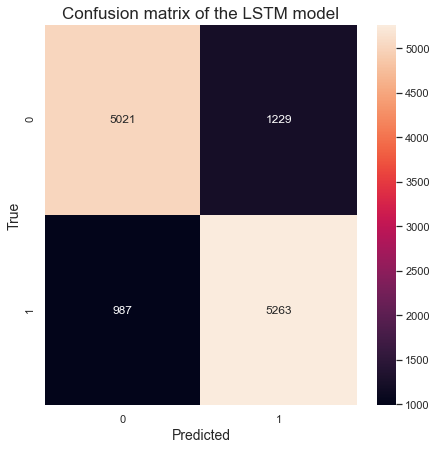

In [33]:
preds_final_lstm = final_lstm.predict(X_test_lstm)
for i in range(len(preds_final_lstm)):
    if preds_final_lstm[i][0] < 0.5:
        preds_final_lstm[i][0] = 0
    else:
        preds_final_lstm[i][0] = 1

print(classification_report(y_test_lstm, preds_final_lstm))

# confusion matrix of the LSTM model
lstm_cm = confusion_matrix(y_test_lstm, preds_final_lstm)
plt.figure(figsize=(7,7))
plt.title('Confusion matrix of the LSTM model', size=17)
seaborn.heatmap(lstm_cm,annot=True, fmt="d")
plt.xlabel('Predicted', size=14)
plt.ylabel('True', size=14)
plt.ioff()
plt.show()

In [45]:
def predict_movie_review_sentiment():
    """
    Predict the sentiment of a movie review based on the input
    using the base model (since it performed the best in our
    analysis)
    
    Returns: sentiment value (str)
    """
    print(f"Please enter your movie review:")
    review = input()
    print("")
    prediction = base_model.predict([review])
    if prediction[0] == 0:
        print("This is a negative review")
    else:
        print("This is a positive review")
    
    
predict_movie_review_sentiment()
print("")
predict_movie_review_sentiment()

Please enter your movie review:
What is this movie?? The acting crew is so unprofessional, the plot is boring to the extent that I left the movie theater half-way through... Such a waste of time:(

This is a negative review

Please enter your movie review:
Wow, this movie literally outperformed my expectations! Surprisingly good ending, graphics were on the highest level and the actors made it seem like the story happened in real life.

This is a positive review
